In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [3]:
#Read csv
data_orig=pd.read_csv("soidukid.csv",on_bad_lines='skip', sep=";")

C:\Users\cardo\AppData\Local\Temp\ipykernel_14588\2727347924.py:2: DtypeWarning: Columns (8,9,21) have mixed types. Specify dtype option on import or set low_memory=False.
  data_orig=pd.read_csv("soidukid.csv",on_bad_lines='skip', sep=";")


In [4]:
#Copying original database
data=data_orig.copy()

In [5]:
#Deleting irrelevant information
data=data[data.YLDINE_STAATUS != "PEATATUD"]
#Resetting indexes to not cause any errors in code below
data=data.reset_index()
#Deleting irrelevant columns
data=data.drop(["Andmed seisuga","index","VARV","ISTEKOHTI", "Kere nimetus", "ARV","Kategooria","Keretüüp","TELGI_KOKKU","TAISMASS", "TYHIMASS","YLDINE_STAATUS","EESTIS_ESMAREG_KP", "MOOTORI_TYYP", "Kütuse tüüp", "HYBRIIDI_TYYP"], axis=1)

In [6]:
#Replacing NaN values in gearbox column with manual transission
#Nan -> manuaal, because manufactoring year of most cars with NaN-values in gearbox column allows to exclude automatic transmission
#on those cars
data["KAIGUKASTI_TYYP"]=data["KAIGUKASTI_TYYP"].fillna("MANUAAL")

In [7]:
#Replacing NaN-values in NEDC column with WLTP values if possible, because the difference between these two aspects
#does not affect the results of our project
for i in range(len(data["CO2_NEDC"])):
    vana=data["CO2_NEDC"].iloc[i]
    uus=data["CO2_WLTP"].iloc[i]
    if str(vana)=="nan" and str(uus)!="nan":
        data.loc[i,'CO2_NEDC']=int(uus)
data=data.drop(["CO2_WLTP"], axis=1)        

In [8]:
#Replacing NEDC NaN values of VAZ with 210-ga, because those cars have the same engines
for i in range(len(data["CO2_NEDC"])):
    mark=data["Mark"].iloc[i]
    if str(mark)=="VAZ":
        data.loc[i,'CO2_NEDC']=210

In [9]:
#Counting NaN values of NEDC by car brands (TOP3 - VolksWagen, Audi, BMW)
brändid={}
for i in range(len(data["CO2_NEDC"])):
    NEDC=data["CO2_NEDC"].iloc[i]
    if str(NEDC)=="nan":
        if str(data["Mark"].iloc[i]) in brändid.keys():
            brändid[str(data["Mark"].iloc[i])]= int(brändid.get(str(data["Mark"].iloc[i])))+1
        else:
            brändid[str(data["Mark"].iloc[i])]= 1             
brändid=dict(sorted(brändid.items(), key=lambda item: item[1]))
#print(brändid)

In [10]:
#Replacing Volkswagen, Audi and BMW most common engines NEDC NaN-values
#motoras={engine_size : NEDC}
motoras_VW={1968.0:146.0, 1896.0:162.0, 2461.0:171.0, 2771.0:255.0, 2967.0:180.0 ,1781.0:190.0, 2792.0:278.0}
motoras_BMW={1596.0:171.6, 1991.0:165.3, 2979.0:169.0, 2993.0:170.0, 2926.0:178.0, 1995.0:153.0, 1796.0:208.0, 1950.0:158.0}

In [11]:
#Replacing Volkswagen and Audi NaN-values in NEDC columns
for i in range(len(data["CO2_NEDC"])):
    mootor=data["MOOTORI_MAHT"].iloc[i]
    NEDC=data["CO2_NEDC"].iloc[i]
    mark=data["Mark"].iloc[i]
    if str(NEDC)=="nan" and float(mootor) in motoras_VW.keys() and (str(mark)=="VOLKSWAGEN" or str(mark)=="AUDI"):
        data.loc[i,'CO2_NEDC']=int(motoras_VW.get(float(mootor)))

In [12]:
#Replacing BMW NaN-values in NEDC column
for i in range(len(data["CO2_NEDC"])):
    mootor=data["MOOTORI_MAHT"].iloc[i]
    NEDC=data["CO2_NEDC"].iloc[i]
    mark=data["Mark"].iloc[i]
    if str(NEDC)=="nan" and float(mootor) in motoras_BMW.keys() and str(mark)=="BMW":
        data.loc[i,'CO2_NEDC']=int(motoras_BMW.get(float(mootor)))

In [13]:
#Replacing all electric car NEDC values with zero, since they do not produce any CO2
for i in range(len(data["CO2_NEDC"])):
    kütus=data["Kütusekombinatsioon"].iloc[i]
    NEDC=data["CO2_NEDC"].iloc[i]
    if str(NEDC)=="nan" and str(kütus)=="ELEKTER":
        data.loc[i,'CO2_NEDC']=0

In [14]:
#Replacing faulty county names and creating list of county names
tundmatud=['L��NE-VIRU MAAKOND', 'P�RNU MAAKOND', 'J�RVA MAAKOND', 'P�LVA MAAKOND', 'V�RU MAAKOND']
asendused=["LÄÄNE-VIRU MAAKOND", "PÄRNU MAAKOND", "JÄRVA MAAKOND", "PÕLVA MAAKOND", "VÕRU MAAKOND"]

for i in range(len(tundmatud)):
    data["VK/OM MAAKOND"]=data["VK/OM MAAKOND"].replace([tundmatud[i]],asendused[i])
    
MAAKONNAD=[]
for i in range(len(data["VK/OM MAAKOND"])):
    maakond=data["VK/OM MAAKOND"].iloc[i]
    if str(maakond) not in MAAKONNAD:
        MAAKONNAD.append(str(maakond))

In [15]:
#Dictionarys, where we can add information about the amount of cars in different counties
autod_maakonnas={'HARJU MAAKOND':0, 'PÄRNU MAAKOND':0, 'TARTU MAAKOND':0, 'VALGA MAAKOND':0, 'VÕRU MAAKOND':0, 'HIIU MAAKOND':0, 'PÕLVA MAAKOND':0, 'SAARE MAAKOND':0, 'LÄÄNE-VIRU MAAKOND':0, 'IDA-VIRU MAAKOND':0, 'JÕGEVA MAAKOND':0, 'LÄÄNE MAAKOND':0, 'RAPLA MAAKOND':0, 'VILJANDI MAAKOND':0, 'JÄRVA MAAKOND':0, 'MÄÄRAMATA':0}
passatid_maakonnas={'HARJU MAAKOND':0, 'PÄRNU MAAKOND':0, 'TARTU MAAKOND':0, 'VALGA MAAKOND':0, 'VÕRU MAAKOND':0, 'HIIU MAAKOND':0, 'PÕLVA MAAKOND':0, 'SAARE MAAKOND':0, 'LÄÄNE-VIRU MAAKOND':0, 'IDA-VIRU MAAKOND':0, 'JÕGEVA MAAKOND':0, 'LÄÄNE MAAKOND':0, 'RAPLA MAAKOND':0, 'VILJANDI MAAKOND':0, 'JÄRVA MAAKOND':0, 'MÄÄRAMATA':0}
passatid_kokku=0

#Counting all cars and passats in different counties
for i in range(len(data["VK/OM MAAKOND"])):
    mudel=data["Mudel"].iloc[i]
    maakond=data["VK/OM MAAKOND"].iloc[i]
    autod_maakonnas[str(maakond)]= int(autod_maakonnas.get(str(maakond)))+1
    if "PASSAT" in str(mudel):
        passatid_kokku+=1
        passatid_maakonnas[str(maakond)]= int(passatid_maakonnas.get(str(maakond)))+1

print("Passateid Eestis " + str(passatid_kokku))

Passateid Eestis 29301


In [16]:
#Procentual porpotion of Passats in every county
for i in range(len(autod_maakonnas)):
    print("Passateid " + str(MAAKONNAD[i]) +" "+ str(round((passatid_maakonnas.get(MAAKONNAD[i])/autod_maakonnas.get(MAAKONNAD[i]))*100,2))+ " %")

Passateid HARJU MAAKOND 3.15 %
Passateid PÄRNU MAAKOND 4.77 %
Passateid TARTU MAAKOND 5.83 %
Passateid VALGA MAAKOND 7.19 %
Passateid VÕRU MAAKOND 9.17 %
Passateid HIIU MAAKOND 4.42 %
Passateid PÕLVA MAAKOND 9.47 %
Passateid SAARE MAAKOND 4.01 %
Passateid LÄÄNE-VIRU MAAKOND 4.5 %
Passateid IDA-VIRU MAAKOND 4.34 %
Passateid JÕGEVA MAAKOND 6.79 %
Passateid LÄÄNE MAAKOND 4.39 %
Passateid RAPLA MAAKOND 4.68 %
Passateid VILJANDI MAAKOND 6.02 %
Passateid JÄRVA MAAKOND 5.24 %
Passateid MÄÄRAMATA 5.09 %


In [17]:
#Creating a dictionary for CO2 emissions in every county
CO2_maakonnas={'HARJU MAAKOND':0, 'PÄRNU MAAKOND':0, 'TARTU MAAKOND':0, 'VALGA MAAKOND':0, 'VÕRU MAAKOND':0, 'HIIU MAAKOND':0, 'PÕLVA MAAKOND':0, 'SAARE MAAKOND':0, 'LÄÄNE-VIRU MAAKOND':0, 'IDA-VIRU MAAKOND':0, 'JÕGEVA MAAKOND':0, 'LÄÄNE MAAKOND':0, 'RAPLA MAAKOND':0, 'VILJANDI MAAKOND':0, 'JÄRVA MAAKOND':0, 'MÄÄRAMATA':0}
#Adding up all NEDC values in every county
for i in range(len(data["CO2_NEDC"])):
    maakond=data["VK/OM MAAKOND"].iloc[i]
    co=data["CO2_NEDC"].iloc[i]
    if str(co)!="nan":
        CO2_maakonnas[str(maakond)]= float(CO2_maakonnas.get(str(maakond))) + float(data["CO2_NEDC"].iloc[i])

In [18]:
CO2_maakonniti=[]
#Printing out avergae CO2 emission by county
for i in range(len(autod_maakonnas)):
    print("CO2 reostus: " + str(MAAKONNAD[i]) +" "+ str(round((CO2_maakonnas.get(MAAKONNAD[i])/autod_maakonnas.get(MAAKONNAD[i])),2))+ " g/km")
    CO2_maakonniti.append(round((CO2_maakonnas.get(MAAKONNAD[i])/autod_maakonnas.get(MAAKONNAD[i])),2))

CO2 reostus: HARJU MAAKOND 135.39 g/km
CO2 reostus: PÄRNU MAAKOND 130.22 g/km
CO2 reostus: TARTU MAAKOND 132.23 g/km
CO2 reostus: VALGA MAAKOND 128.28 g/km
CO2 reostus: VÕRU MAAKOND 126.91 g/km
CO2 reostus: HIIU MAAKOND 126.16 g/km
CO2 reostus: PÕLVA MAAKOND 125.81 g/km
CO2 reostus: SAARE MAAKOND 123.84 g/km
CO2 reostus: LÄÄNE-VIRU MAAKOND 128.83 g/km
CO2 reostus: IDA-VIRU MAAKOND 136.76 g/km
CO2 reostus: JÕGEVA MAAKOND 128.85 g/km
CO2 reostus: LÄÄNE MAAKOND 127.26 g/km
CO2 reostus: RAPLA MAAKOND 129.13 g/km
CO2 reostus: VILJANDI MAAKOND 127.29 g/km
CO2 reostus: JÄRVA MAAKOND 129.86 g/km
CO2 reostus: MÄÄRAMATA 134.01 g/km


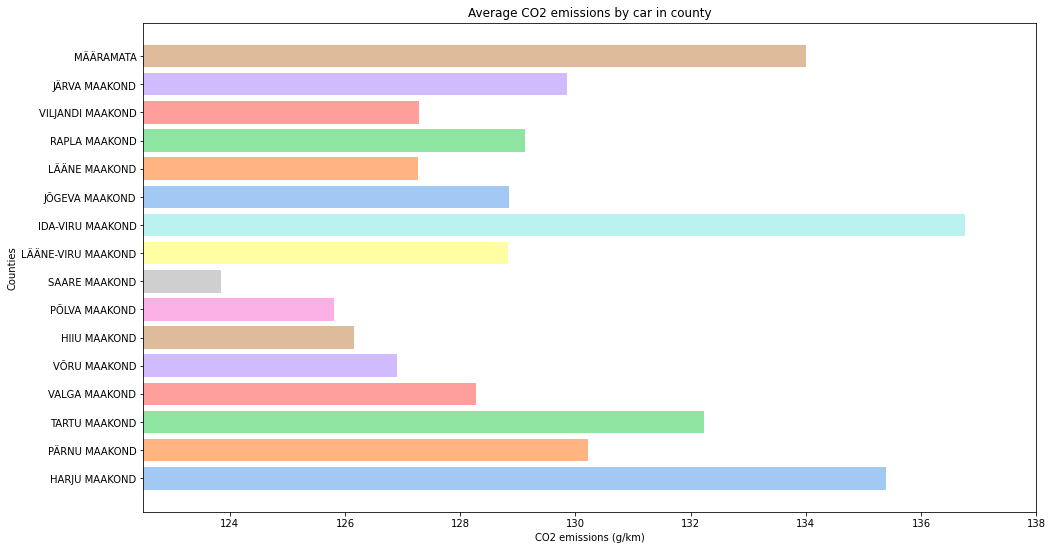

In [19]:
#Graph representing average CO2 emissions by car in county
colors = sns.color_palette('pastel')[0:16]
fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(MAAKONNAD, CO2_maakonniti, color=colors)

ax.set_xlabel('CO2 emissions (g/km)')
ax.set_ylabel('Counties')
ax.set_title('Average CO2 emissions by car in county')

plt.xlim([122.5,138])

plt.show()

In [20]:
#Dictionary of all car brands in database
margid={}
for i in range(len(data["Mark"])):
    mark=data["Mark"].iloc[i]
    if str(mark) not in margid:
        margid[str(mark)]=1  

In [21]:
#top 3 most popular car brands
for i in range(len(data["Mark"])):
    mark=data["Mark"].iloc[i]
    margid[str(mark)]=margid.get(str(mark))+1
margid=dict(sorted(margid.items(), key=lambda item: item[1]))
print(list(margid.keys())[-1])
print(list(margid.keys())[-2])
print(list(margid.keys())[-3])

VOLKSWAGEN
TOYOTA
AUDI


In [22]:
#Dictionarys for all car models of TOP 3 most popular car brands
mudelid_vw={}
mudelid_toyota={}
mudelid_audi={}

for i in range(len(data["Mudel"])):
    mark=data["Mark"].iloc[i]
    mudel=data["Mudel"].iloc[i]
    if str(mark) == "VOLKSWAGEN":
        if str(mudel) not in mudelid_vw:
            mudelid_vw[str(mudel)]=1
        else:
            mudelid_vw[str(mudel)]=mudelid_vw.get(str(mudel))+1
    elif str(mark) == "TOYOTA":
        if str(mudel) not in mudelid_toyota:
            mudelid_toyota[str(mudel)]=1
        else:
            mudelid_toyota[str(mudel)]=mudelid_toyota.get(str(mudel))+1
    elif str(mark) == "AUDI":
        if str(mudel) not in mudelid_audi:
            mudelid_audi[str(mudel)]=1
        else:
            mudelid_audi[str(mudel)]=mudelid_audi.get(str(mudel))+1

In [28]:
mudelid_audi=dict(sorted(mudelid_audi.items(), key=lambda item: item[1]))
mudelid_toyota=dict(sorted(mudelid_toyota.items(), key=lambda item: item[1]))
mudelid_vw=dict(sorted(mudelid_vw.items(), key=lambda item: item[1]))

print("AUDI TOP 3: ")
print(list(mudelid_audi.keys())[-1] + " " + str(list(mudelid_audi.values())[-1]))
print(list(mudelid_audi.keys())[-2] + " " + str(list(mudelid_audi.values())[-2]))
print(list(mudelid_audi.keys())[-3] + " " + str(list(mudelid_audi.values())[-3]))
print(list(mudelid_audi.keys())[-4] + " " + str(list(mudelid_audi.values())[-4]))
print(list(mudelid_audi.keys())[-5] + " " + str(list(mudelid_audi.values())[-5]))
print(list(mudelid_audi.keys())[-6] + " " + str(list(mudelid_audi.values())[-6]))
print()
print("Volkswagen TOP 3: ")
print(list(mudelid_vw.keys())[-1] + " " + str(list(mudelid_vw.values())[-1]))
print(list(mudelid_vw.keys())[-2] + " " + str(list(mudelid_vw.values())[-2]))
print(list(mudelid_vw.keys())[-3] + " " + str(list(mudelid_vw.values())[-3]))
print(list(mudelid_vw.keys())[-4] + " " + str(list(mudelid_vw.values())[-4]))
print(list(mudelid_vw.keys())[-5] + " " + str(list(mudelid_vw.values())[-5]))
print()
print("Toyota TOP 3: ")
print(list(mudelid_toyota.keys())[-1] + " " + str(list(mudelid_toyota.values())[-1]))
print(list(mudelid_toyota.keys())[-2] + " " + str(list(mudelid_toyota.values())[-2]))
print(list(mudelid_toyota.keys())[-3] + " " + str(list(mudelid_toyota.values())[-3]))

AUDI TOP 3: 
A6 AVANT 9388
A4 AVANT 7386
A4 4823
A6 4654
80 3108
Q7 2741

Volkswagen TOP 3: 
PASSAT 17186
GOLF 12824
PASSAT VARIANT 11602
GOLF VARIANT 4550
TIGUAN 4194

Toyota TOP 3: 
AVENSIS 14472
COROLLA 11504
RAV4 11358


In [30]:
#All engine sizes
mootori_maht = {}
mootori_mahud = []
mootoreid = []
data["MOOTORI_MAHT"] = data["MOOTORI_MAHT"].fillna(0)
for i in range(len(data["MOOTORI_MAHT"])):
    maht = data["MOOTORI_MAHT"].iloc[i]
    mahtr = round(int(maht)/1000,1)
    if str(mahtr) not in mootori_maht:
        mootori_maht[str(mahtr)] = 1
    else:
        mootori_maht[str(mahtr)]=mootori_maht.get(str(mahtr))+1
mootori_maht=dict(sorted(mootori_maht.items(), key=lambda item: item[1]))

In [31]:
#All engine sizes with users over 25000
for key, value in mootori_maht.items():
    if int(value) > 25000:
        mootori_mahud.append(key) 
        mootoreid.append(value)

In [32]:
#Sorting engine sizes
res = {}
mootorcopy = mootoreid.copy()
for key in mootori_mahud:
    for value in mootorcopy:
        res[key] = value
        mootorcopy.remove(value)
        break
res=dict(sorted(res.items(), key=lambda item: item[1]))

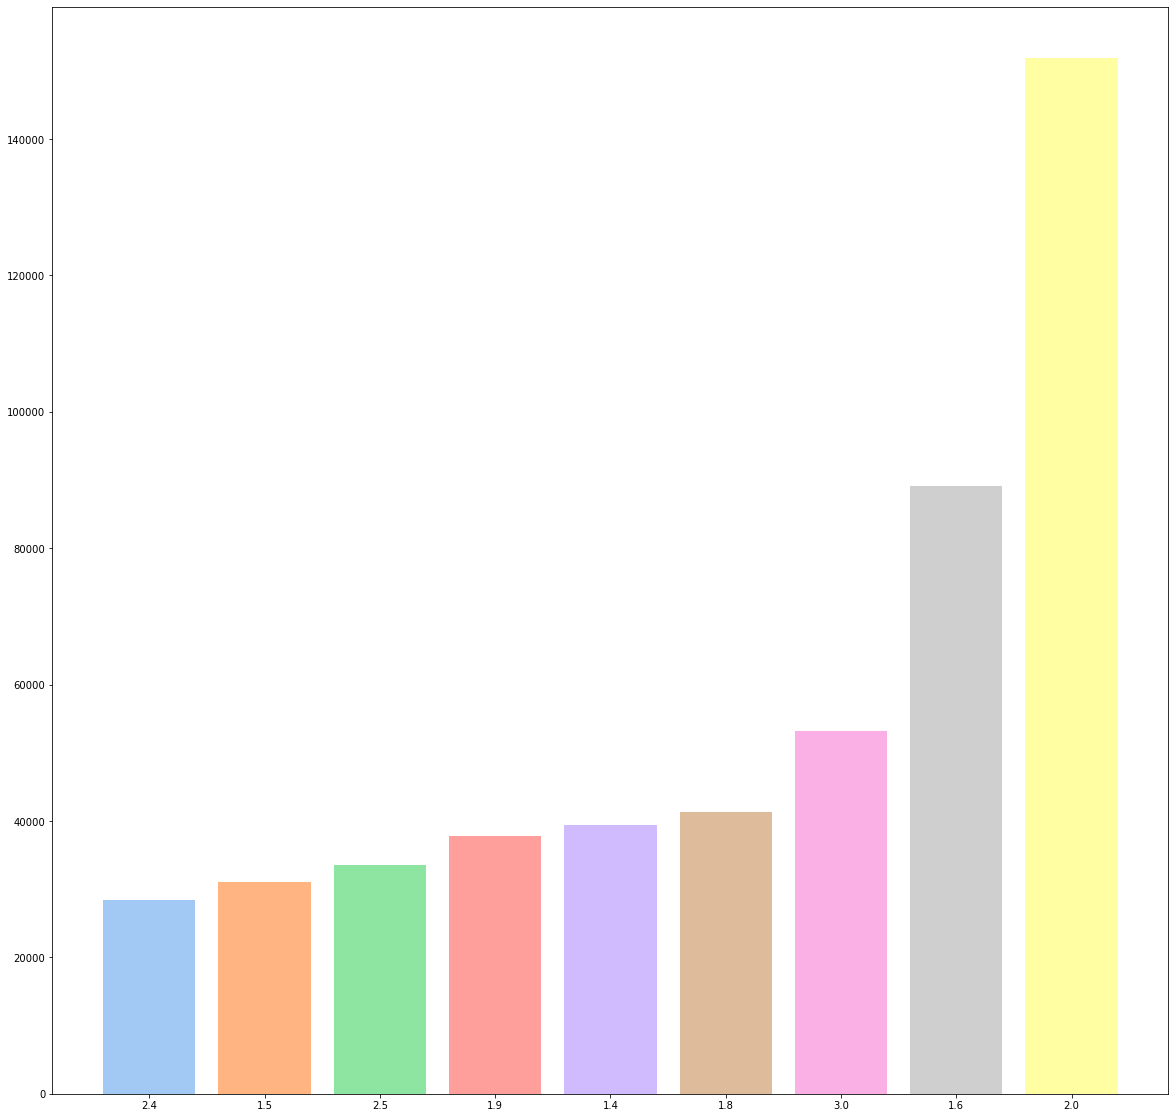

In [47]:
#Graph representing most popular engine sizes in Estonia
colors = sns.color_palette('pastel')[0:9]
plt.figure(figsize = (20,20))
plt.bar(*zip(*res.items()), color=colors)
#plt.title('Most popular engine sizes')
#plt.ylabel('Popularity')
#plt.xlabel('Engine size (l)')
plt.show()
#plt.savefig('engine_sizes.png')

In [34]:
#Dictionary of all fuel types and amount of cars that use them
kütused = {}
data["Kütusekombinatsioon"] = data["Kütusekombinatsioon"].fillna("TEADMATA")
for i in range(len(data["Kütusekombinatsioon"])):
    kütus = data["Kütusekombinatsioon"].iloc[i]
    if str(kütus) not in kütused:
        kütused[str(kütus)] = 1
    else:
        kütused[str(kütus)]=kütused.get(str(kütus))+1
kütused=dict(sorted(kütused.items(), key=lambda item: item[1]))
kütused = dict(reversed(list(kütused.items())))

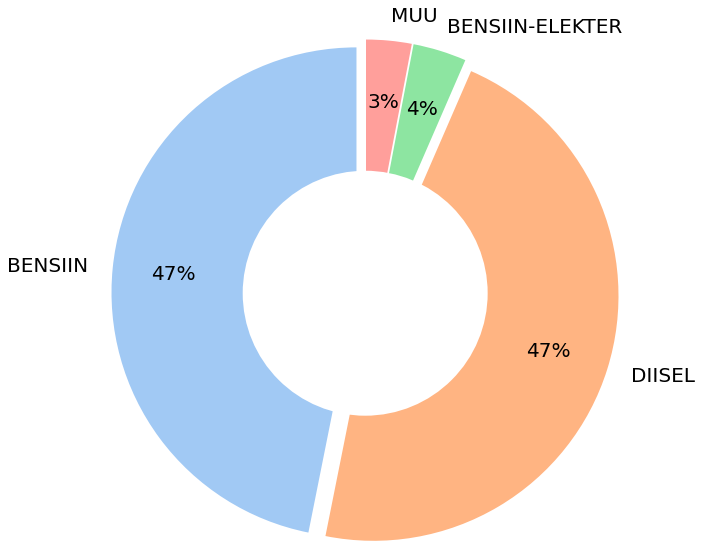

In [38]:
# Pie chart representing most popular fuel types
labels = []
sizes = []

colors = sns.color_palette('pastel')[0:5]
muu_suurus=0
for x, y in kütused.items():
    if str(x)=="DIISEL" or str(x)=="BENSIIN" or str(x)=="BENSIIN-ELEKTER":
        labels.append(x)
        sizes.append(y)
    else:
        muu_suurus+=y

labels.append("MUU")
sizes.append(muu_suurus)

#explsion
explode = (0.05,0.05,0.05,0.05)
 
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.0f%%', startangle=90, pctdistance=0.75, explode = explode, radius=1.4, textprops={'fontsize': 20})
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.set_size_inches(10,10)
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
#ax1.axis('equal')  
plt.tight_layout()
plt.show()

In [39]:
#Dictionary for all gearbox types and their usage
käigukastid = {}
data["KAIGUKASTI_TYYP"] = data["KAIGUKASTI_TYYP"].fillna("TEADMATA")
for i in range(len(data["KAIGUKASTI_TYYP"])):
    käigukast = data["KAIGUKASTI_TYYP"].iloc[i]
    if str(käigukast) not in käigukastid:
        käigukastid[str(käigukast)] = 1
    else:
        käigukastid[str(käigukast)]=käigukastid.get(str(käigukast))+1
käigukastid=dict(sorted(käigukastid.items(), key=lambda item: item[1]))
käigukastid = dict(reversed(list(käigukastid.items())))

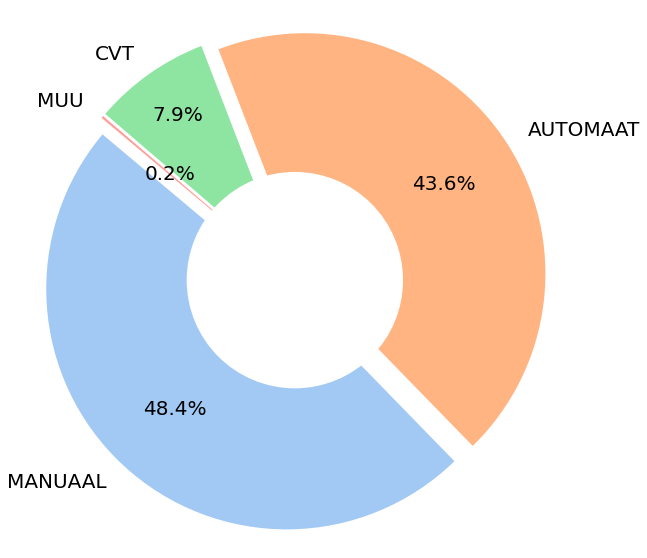

In [42]:
#Pie chart to represent most popular gearbox types
fig =plt.figure(figsize = (4,4))
ax11 = fig.add_subplot(111)
# Data to plot

labels = []
sizes = []

colors = sns.color_palette('pastel')[0:5]
muu_suurus=0
for x, y in käigukastid.items():
    if str(x)=="MANUAAL" or str(x)=="AUTOMAAT" or str(x)=="CVT":
        labels.append(x)
        sizes.append(y)
    else:
        muu_suurus+=y

labels.append("MUU")
sizes.append(muu_suurus)

explode = (0.05,0.05,0.05,0.05)

# Plot
w,l,p = ax11.pie(sizes,  labels=labels, colors=colors,
        autopct='%1.1f%%', startangle=140, pctdistance=1, explode=explode,textprops={'fontsize': 20})

pctdists = [.7, .7, .8, .65]

for t,d in zip(p, pctdists):
    xi,yi = t.get_position()
    ri = np.sqrt(xi**2+yi**2)
    phi = np.arctan2(yi,xi)
    x = d*ri*np.cos(phi)
    y = d*ri*np.sin(phi)
    t.set_position((x,y))
    
centre_circle = plt.Circle((0,0),0.45,fc='white')
fig = plt.gcf()
fig.set_size_inches(10,10)
fig.gca().add_artist(centre_circle)

plt.axis('equal')
plt.show()

In [41]:
#Dictionary for manufacturing years and the amount of cars manufactured in that year
aastad = {}
for i in range(len(data["ESMANE_REG_KP"])):
    aasta = int(str(data["ESMANE_REG_KP"].iloc[i])[6:10])
    if aasta not in aastad:
        aastad[aasta] = 1
    else:
        aastad[aasta]=aastad.get(aasta)+1

In [58]:
#Sorting dictionary
aastad=dict(sorted(aastad.items(), key=lambda item: item[1]))
#Dividing manufacturing years into different time periods
aasta_vahemikud = ["1900-1989", "1990-1999", "2000-2005", "2006-2010", "2010-2015", "2016-2020", "2021+"]
autode_arv_vahemikus = [0,0,0,0,0,0,0]

for key, value in aastad.items():
    if key > 1899 and key < 1990:
        autode_arv_vahemikus[0] = autode_arv_vahemikus[0] + value
    elif key > 1899 and key < 2000:
        autode_arv_vahemikus[1] = autode_arv_vahemikus[1] + value
    elif key > 1999 and key < 2006:
        autode_arv_vahemikus[2] = autode_arv_vahemikus[2] + value
    elif key > 2005 and key < 2011:
        autode_arv_vahemikus[3] = autode_arv_vahemikus[3] + value
    elif key > 2010 and key < 2016:
        autode_arv_vahemikus[4] = autode_arv_vahemikus[4] + value
    elif key > 2015 and key < 2021:
        autode_arv_vahemikus[5] = autode_arv_vahemikus[5] + value
    else:
        autode_arv_vahemikus[6] = autode_arv_vahemikus[6] + value

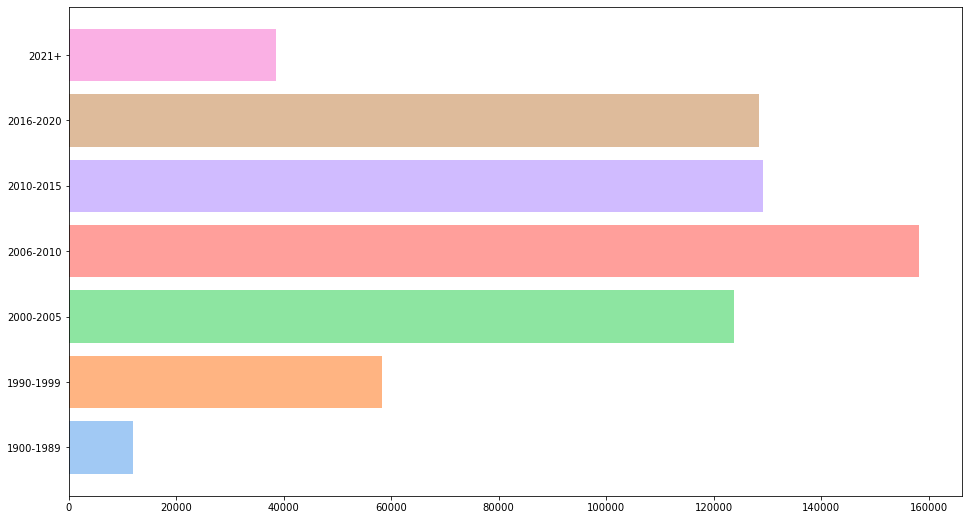

In [59]:
#Bar chart to represent most popular manufacturing years of cars in Estonia
colors = sns.color_palette('pastel')[0:7]

fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(aasta_vahemikud, autode_arv_vahemikus, color=colors)

#ax.set_xlabel('Number of cars')
#ax.set_ylabel('Years')
#ax.set_title('What manufacturing year are estonian cars')

plt.show()

In [60]:
võimsuse_vahemikud = ["0-50", "51-100", "101-150", "151-200", "201-250", "251+"]
autode_arv_võimsuse_vahemikus = [0,0,0,0,0,0]

for i in range(len(data["MOOTORI_VOIMSUS"])):
    võimsus_str = str(data["MOOTORI_VOIMSUS"].iloc[i])
    if ',' in võimsus_str:
        võimsus_str=võimsus_str.replace(",",".")
        data["MOOTORI_VOIMSUS"].iloc[i] = võimsus_str
        
    võimsus = float(võimsus_str)
    if võimsus <= 50:
        autode_arv_võimsuse_vahemikus[0] = autode_arv_võimsuse_vahemikus[0] + 1
    elif võimsus <= 100 and võimsus > 50:
        autode_arv_võimsuse_vahemikus[1] = autode_arv_võimsuse_vahemikus[1] + 1
    elif võimsus <= 150 and võimsus > 100:
        autode_arv_võimsuse_vahemikus[2] = autode_arv_võimsuse_vahemikus[2] + 1
    elif võimsus <= 200 and võimsus > 150:
        autode_arv_võimsuse_vahemikus[3] = autode_arv_võimsuse_vahemikus[3] + 1
    elif võimsus <= 250 and võimsus > 200:
        autode_arv_võimsuse_vahemikus[4] = autode_arv_võimsuse_vahemikus[4] + 1
    else:
        autode_arv_võimsuse_vahemikus[5] = autode_arv_võimsuse_vahemikus[5] + 1
    

C:\Users\cardo\AppData\Local\Temp\ipykernel_14588\4257786698.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["MOOTORI_VOIMSUS"].iloc[i] = võimsus_str


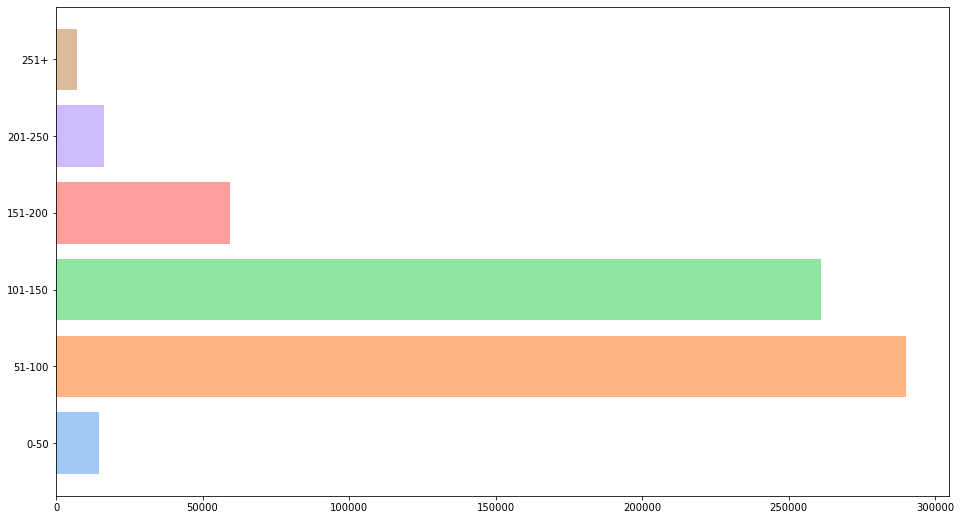

In [61]:
colors = sns.color_palette('pastel')[0:6]
fig, ax = plt.subplots(figsize =(16, 9))

ax.barh(võimsuse_vahemikud, autode_arv_võimsuse_vahemikus, color=colors)

#ax.set_xlabel('Autode arv')
#ax.set_ylabel('Võimsus')
#ax.set_title('Kui võimsad on Eesti rahva autod')

plt.show()

In [62]:
#Copying data for prediction process
big_predict=data.copy()

In [63]:
#Changing original data, preparing data for prediction process
big_predict["AASTA"]=data["ESMANE_REG_KP"].str[-4:]
big_predict=big_predict.drop(["ESMANE_REG_KP","Mark","Mudel","VK/OM MAAKOND", "HEITMENORM"], axis=1)
big_predict=big_predict.dropna()

In [64]:
#Fixing indexes
big_predict=big_predict.reset_index()
big_predict=big_predict.drop(["index"], axis=1)

In [65]:
#Changing aspects with very low values to "muu"
vägaoluline=["BENSIIN-CNG-LPG","DIISEL-LPG","BENSIIN-LNG","ELEKTER-VESINIK","BENSIIN-CNG-ETANOOL","CNG-LPG","LPG","BENSIIN-ETANOOL-LPG","BENSIIN-ETANOOL","BENSIIN-ELEKTER-LPG", "BENSIIN-CNG","DIISEL-ELEKTER", "BENSIIN-LPG", "BENSIIN-ELEKTER"] 
for i in range(len(vägaoluline)):
    big_predict["Kütusekombinatsioon"]=big_predict["Kütusekombinatsioon"].replace([vägaoluline[i]],"MUU")

In [66]:
#Data to binary form
columns = big_predict.columns
big_predict = pd.get_dummies(big_predict, columns=['KAIGUKASTI_TYYP', "Kütusekombinatsioon"])

In [67]:
#Shuffling data
shuffle_data = big_predict.sample(frac = 1)
shuffle_data=shuffle_data.reset_index()
shuffle_data=shuffle_data.drop(["index"], axis=1)

In [68]:
#Splitting data into train and test set
X_train, X_test, y_train, y_test = train_test_split(shuffle_data.iloc[:, shuffle_data.columns!="CO2_NEDC"],shuffle_data["CO2_NEDC"], test_size=0.25, random_state=1)

In [69]:
#Regressions
linear = LinearRegression()
ridge = Ridge()
lasso = Lasso()

In [70]:
#Predicting algorithm realization, comparing actual and predicted values
linear.fit(X_train,y_train)
y_pred = linear.predict(X_test)
df_preds = pd.DataFrame({"Actual":y_test.squeeze(), "pred":y_pred.squeeze()})
print(df_preds)
print(linear.score(X_train, y_train))
print(linear.score(X_test, y_test))
print(linear.coef_)

        Actual        pred
63585    125.0  116.191384
363301   143.0  122.795618
38534     85.0   88.490880
491218   125.0  124.554640
437934   112.0   87.745140
...        ...         ...
319970   162.0  164.775089
220472   182.0  185.496552
213357   246.0  193.869021
427739   114.0  108.428925
433794   219.0  266.843433

[134275 rows x 2 columns]
0.7825768225509446
0.7789042262313243
[ 3.04706791e-02 -5.38717909e-02  4.97159886e-02 -3.07622290e+00
  7.75736880e-01  2.12816752e+01 -1.05985815e+01  3.57486148e+01
 -1.00935227e+01 -5.80239594e+00 -3.13115267e+01  4.13306559e+01
  8.21440423e+00  6.09416083e+00 -6.24452756e+01  6.80605473e+00]


In [71]:
#Choosing gearbox for future CO2 predictions
autosid = 0
automaate = 0
manuaale = 0
for i in range(len(data["ESMANE_REG_KP"])):
    aasta = int(str(data["ESMANE_REG_KP"].iloc[i])[-4:])
    if aasta >= 2010:
        if str(data["KAIGUKASTI_TYYP"].iloc[i]) == "MANUAAL":
            autosid += 1
            manuaale += 1
        elif str(data["KAIGUKASTI_TYYP"].iloc[i]) == "AUTOMAAT":
            autosid += 1
            automaate += 1
            
print(str((manuaale/autosid)*100) + " %")
print(str((automaate/autosid)*100) + " %")        

35.85075364103169 %
64.14924635896831 %


In [72]:
#Choosing the engine power output
mootori_võimsused = []
for i in range(len(data["MOOTORI_VOIMSUS"])):
    võimsus_str = str(data["MOOTORI_VOIMSUS"].iloc[i])  
    võimsus = float(võimsus_str)
    aasta = int(str(data["ESMANE_REG_KP"].iloc[i])[-4:])
    if aasta >= 2010:
        mootori_võimsused.append(võimsus)

auto_võimsus = round(sum(mootori_võimsused)/len(mootori_võimsused))
print(auto_võimsus)

118


In [73]:
#Predictions
autod_bensiin = []
autod_diisel = []
aastad = [2025, 2030, 2035, 2040]
for i in range(len(aastad)):
    autod_diisel.append(linear.predict([[2000, auto_võimsus, 1500, aastad[i], 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])[0])
    autod_bensiin.append(linear.predict([[2000, auto_võimsus, 1500, aastad[i], 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])[0])
    
print(autod_diisel)
print(autod_bensiin)

[76.94675469327558, 61.56564018183144, 46.1845256703873, 30.803411158943163]
[112.18324971693437, 96.80213520549023, 81.42102069404609, 66.03990618260195]


C:\Users\cardo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cardo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cardo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cardo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cardo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\cardo\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not ha

<Figure size 1440x1440 with 0 Axes>

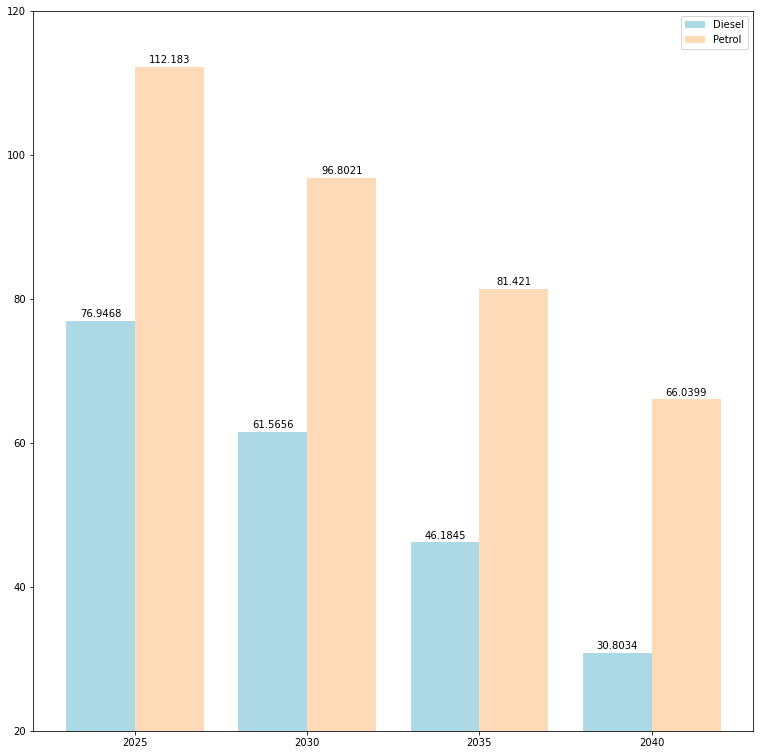

In [74]:
#Representing prediction results on graph

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)



plt.figure(figsize = (20,20))

x = np.arange(len(aastad))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, autod_diisel, width, label='Diesel', color="lightblue")
rects2 = ax.bar(x + width/2, autod_bensiin, width, label='Petrol', color="peachpuff")

# Add some text for labels, title and custom x-axis tick labels, etc.
#ax.set_ylabel('CO2 emissions')
#ax.set_title('Predicted CO2 emissions in future')
ax.set_xticks(x, aastad)
ax.legend()
set_size(10,10)
plt.ylim((20,120))
ax.bar_label(rects1, padding=2)
ax.bar_label(rects2, padding=2)

#fig.tight_layout()

plt.show()